# Model Development

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seaborn as sns
import plotly.express as px
import pickle as pkl

dataset = "male_players (legacy)_23"
# dataset = "female_players (legacy)_23"
df = pd.read_csv('Data/Preprocessed/Clean_'+dataset+'.csv')
print(len(df))

158866


# Normalization

In [26]:
df.describe()
# We notice that some features have very big values, while others are very small
# So we should normalize

,player_id,fifa_version,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_id,...,work_rate_attack_High,work_rate_attack_Low,work_rate_attack_Medium,work_rate_defend_High,work_rate_defend_Low,work_rate_defend_Medium,body_type_Lean,body_type_Normal,body_type_Stocky,body_type_Unique
count,158866.000000,158866.000000,158866.000000,158866.000000,1.585810e+05,158866.000000,158866.000000,158866.000000,158866.000000,158866.000000,...,158866.000000,158866.000000,158866.000000,158866.000000,158866.000000,158866.000000,158866.000000,158866.000000,158866.000000,158866.000000
mean,214527.914053,19.142535,65.658536,70.738931,2.326804e+06,10858.744162,25.089931,181.244074,75.226115,211.207691,...,0.261220,0.050835,0.687945,0.162590,0.090258,0.747152,0.344019,0.594759,0.058471,0.002751
std,34988.592350,2.561783,7.052763,6.266821,6.018702e+06,21962.307385,4.667724,6.747477,6.999496,445.883183,...,0.439301,0.219662,0.463334,0.368992,0.286553,0.434646,0.475049,0.490940,0.234632,0.052376
min,2.000000,15.000000,40.000000,40.000000,1.000000e+03,500.000000,16.000000,154.000000,49.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,199199.000000,17.000000,61.000000,66.000000,3.250000e+05,2000.000000,21.000000,176.000000,70.000000,19.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,220668.000000,19.000000,66.000000,70.000000,7.250000e+05,4000.000000,25.000000,181.000000,75.000000,56.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,237055.000000,21.000000,70.000000,75.000000,1.800000e+06,10000.000000,28.000000,186.000000,80.000000,308.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,271817.000000,23.000000,94.000000,95.000000,1.940000e+08,575000.000000,54.000000,208.000000,110.000000,2149.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
val_eur_avg_before_scaling = df['value_eur'].mean()
overall_avg_before_scaling = df['overall'].mean()

In [28]:
# Normalize all the columns except object type
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

overall_max_min = df['overall'].max(), df['overall'].min()
value_eur_max_min = df['value_eur'].max(), df['value_eur'].min()

for col in df.columns:
    # check type of column not object
    if df[col].dtype != 'object' and col != 'player_id':
        df[col] = scaler.fit_transform(df[[col]])

In [29]:
df.to_csv('Data/Preprocessed/Normalized_'+dataset+'.csv', index = False)

In [30]:
# Now load this data in the next script
df = pd.read_csv('Data/Preprocessed/Normalized_'+dataset+'.csv')

In [31]:
# column names of type object
object_columns = df.select_dtypes(include=['object']).columns
print(object_columns)

Index(['short_name', 'player_positions', 'league_name', 'club_name',
       'club_position', 'nationality_name'],
      dtype='object')


# Feature Extraction

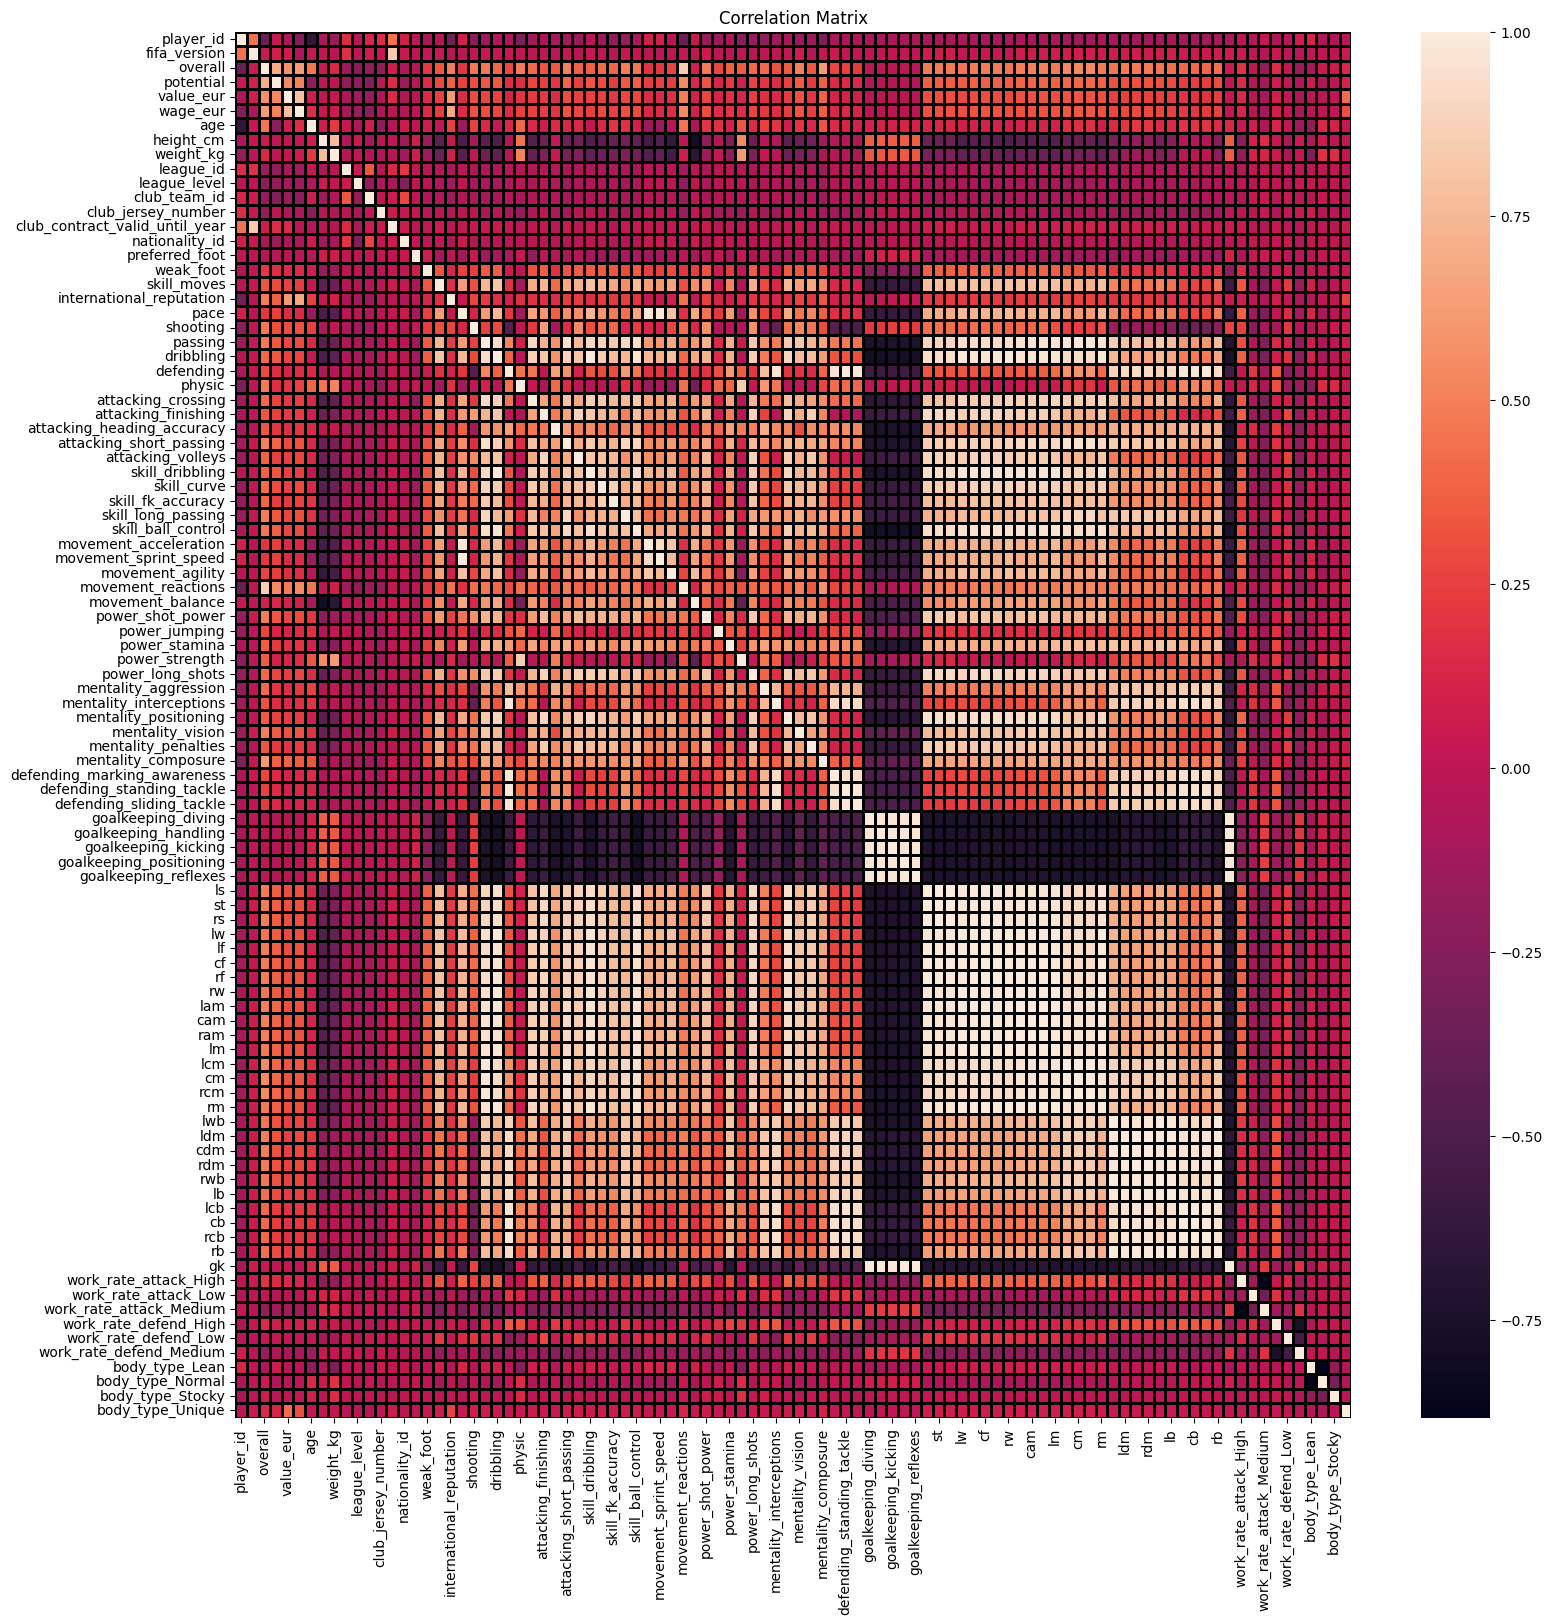

In [32]:
# making a heatmap of the correlation matrix
df2 = df.copy()
# dropping the categorical columns
df2 = df2.drop(columns = ['short_name', 'player_positions', 'league_name', 'club_name',
       'club_position', 'nationality_name'])

plt.figure(figsize=(18,18))
sns.heatmap(df2.corr(), cbar = True, linewidths=1, linecolor='black')
# sns.heatmap(df2.corr(), annot= False, cmap='jet')
plt.title('Correlation Matrix')
plt.show()

In [33]:
df2 = df.copy()
df2 = df2.drop(columns = ['short_name', 'player_positions', 'league_name', 'club_name',
       'club_position', 'nationality_name'])

correlation_with_val_eur = np.abs(df2.corrwith(df2['value_eur']))            # absolute to handle -ve values
sorted_correlations = correlation_with_val_eur.sort_values(ascending=False)
# Take top correlations > 0.2
top_correlations = sorted_correlations[sorted_correlations > 0.2]
print(len(top_correlations))
print(top_correlations[:60])

50
value_eur                   1.000000
wage_eur                    0.779419
international_reputation    0.604807
overall                     0.566806
potential                   0.533896
movement_reactions          0.490547
body_type_Unique            0.424834
mentality_composure         0.381837
rcm                         0.326662
cm                          0.326662
lcm                         0.326662
mentality_vision            0.320191
ram                         0.314159
cam                         0.314159
lam                         0.314159
rm                          0.302093
lm                          0.302093
rs                          0.302002
st                          0.302002
ls                          0.302002
cf                          0.300799
lf                          0.300799
rf                          0.300799
attacking_short_passing     0.295699
shooting                    0.294341
rw                          0.286438
lw                          0.28643

In [34]:
selected_features = top_correlations[1:16].index.tolist()
print(top_correlations)


value_eur                   1.000000
wage_eur                    0.779419
international_reputation    0.604807
overall                     0.566806
potential                   0.533896
movement_reactions          0.490547
body_type_Unique            0.424834
mentality_composure         0.381837
rcm                         0.326662
cm                          0.326662
lcm                         0.326662
mentality_vision            0.320191
ram                         0.314159
cam                         0.314159
lam                         0.314159
rm                          0.302093
lm                          0.302093
rs                          0.302002
st                          0.302002
ls                          0.302002
cf                          0.300799
lf                          0.300799
rf                          0.300799
attacking_short_passing     0.295699
shooting                    0.294341
rw                          0.286438
lw                          0.286438
p

# Model Development

In [35]:
def Descale(val, max, min):
    return val * (max - min) + min

## Value Euro

In [40]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# drop nan values from df
df = df.dropna()
print(selected_features)
x_data = df[selected_features]
y_data = df['value_eur']

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(x_val)

# descale y_pred
y_pred_descaled = Descale(y_pred, *value_eur_max_min)
# y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
# print(y_pred_descaled[:10])
print("Avg before scaling:", val_eur_avg_before_scaling)
print("Predicted Avg after descaling:", np.mean(y_pred_descaled))

mae = mean_absolute_error(y_val, y_pred)
print("Mean Absolute Error:", mae)
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

# Accuracy
accuracy = model.score(x_val, y_val)        # by-predict bl x_val, b3dein y-compare bl y_val
print("Accuracy:", accuracy)

# Dataset: Male Players (Legacy) 23
# Mean Absolute Error: 0.0022448626715010785
# Mean Squared Error: 4.681499081007544e-05
# Accuracy: 0.9493935800283185



['wage_eur', 'international_reputation', 'overall', 'potential', 'movement_reactions', 'body_type_Unique', 'mentality_composure', 'rcm', 'cm', 'lcm', 'mentality_vision', 'ram', 'cam', 'lam', 'rm']
Avg before scaling: 2326804.043359545
Predicted Avg after descaling: 2333158.8
Mean Absolute Error: 0.00230869881694891
Mean Squared Error: 5.553002175353285e-05
Accuracy: 0.9399727404989453


In [37]:
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold, RepeatedStratifiedKFold, LeaveOneOut

x_data = df[selected_features]
y_data = df['value_eur']

# 1. Setup the folds
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# 2. Perform cross-validation
kfold_cv_scores = cross_val_score(model, x_data, y_data, cv=kfold_cv)
print("\nSimple k-fold cross-validation scores:", kfold_cv_scores)
print("Mean accuracy:", np.mean(kfold_cv_scores))

# Dataset: Male Players (Legacy) 23
# Simple k-fold cross-validation scores: [0.94939358 0.95799031 0.94560174 0.95388817 0.95284557]
# Mean accuracy: 0.951943873760891


Simple k-fold cross-validation scores: [0.93997274 0.95181638 0.94051464 0.95023959 0.94559422]
Mean accuracy: 0.9456275153922855


In [38]:
# from sklearn.svm import SVR

# model = SVR()       # SVM for regression
# model.fit(x_train, y_train)

# y_pred = model.predict(x_val)
# mae = mean_absolute_error(y_val, y_pred)
# print("Mean Absolute Error:", mae)

# mse = mean_squared_error(y_val, y_pred)
# print("Mean Squared Error:", mse)

# accuracy = model.score(x_val, y_val)
# print("Accuracy:", accuracy)
# # Horrendous results after so much time (around 28 mins)



In [39]:
# use knn to predict
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(x_val)
mae = mean_absolute_error(y_val, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

accuracy = model.score(x_val, y_val)
print("Accuracy:", accuracy)

# Dataset:
# Mean Absolute Error: 0.0027787033023255357
# Mean Squared Error: 0.00010119517923888665
# Accuracy: 0.8906092759806647

Mean Absolute Error: 0.0027787033023255357
Mean Squared Error: 0.00010119517923888665
Accuracy: 0.8906092759806647


## Overall

In [15]:
# check object types
df.select_dtypes(include = 'object').columns

Index(['short_name', 'player_positions', 'league_name', 'club_name',
       'club_position', 'nationality_name'],
      dtype='object')

In [16]:
df2 = df.copy()
df2 = df2.drop(columns = ['short_name', 'player_positions', 'league_name', 'club_name',
       'club_position', 'nationality_name'])


correlation_with_overall = np.abs(df2.corrwith(df2['overall']))            # absolute to handle -ve values
sorted_correlations = correlation_with_overall.sort_values(ascending=False)
# Take top correlations > 0.4
top_correlations = sorted_correlations[sorted_correlations > 0.4]
print(len(top_correlations))
print(top_correlations[:60])

43
overall                     1.000000
movement_reactions          0.846797
potential                   0.694976
wage_eur                    0.612524
mentality_composure         0.606810
value_eur                   0.566806
rcm                         0.542518
cm                          0.542518
lcm                         0.542518
attacking_short_passing     0.502546
mentality_vision            0.494744
ram                         0.492909
cam                         0.492909
lam                         0.492909
international_reputation    0.487602
skill_long_passing          0.485840
rs                          0.483244
st                          0.483244
ls                          0.483244
power_shot_power            0.482711
rdm                         0.482699
ldm                         0.482699
cdm                         0.482699
physic                      0.478515
lf                          0.478137
cf                          0.478137
rf                          0.47813

In [22]:
selected_features = top_correlations[1:16].index.tolist()

In [23]:
# drop nan values from df
df = df.dropna()

x_data = df[selected_features]
y_data = df['overall']

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(x_train, y_train)

y_pred = model.predict(x_val)

y_pred_descaled = Descale(y_pred, *overall_max_min)
print("Avg before scaling:", overall_avg_before_scaling)
print("Predicted Avg after descaling:", np.mean(y_pred_descaled))

mae = mean_absolute_error(y_val, y_pred)
print("Mean Absolute Error:", mae)
mse = mean_squared_error(y_val, y_pred)
print("Mean Squared Error:", mse)

# Accuracy
accuracy = model.score(x_val, y_val)        # by-predict bl x_val, b3dein y-compare bl y_val
print("Accuracy:", accuracy)

# Dataset: Male Players (Legacy) 23
# Mean Absolute Error: 0.01871492797796914
# Mean Squared Error: 0.0006464571740591109
# Accuracy: 0.9621493492118541

Avg before scaling: 65.6585361247844
Predicted Avg after descaling: 65.68986
Mean Absolute Error: 0.01871492797796914
Mean Squared Error: 0.0006464571740591109
Accuracy: 0.9621493492118541


In [19]:
x_data = df[selected_features]
y_data = df['value_eur']

# 1. Setup the folds
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# 2. Perform cross-validation
kfold_cv_scores = cross_val_score(model, x_data, y_data, cv=kfold_cv)
print("\nSimple k-fold cross-validation scores:", kfold_cv_scores)
print("Mean accuracy:", np.mean(kfold_cv_scores))

# Dataset: Male Players (Legacy) 23
# Simple k-fold cross-validation scores: [0.96367937 0.97212427 0.97449062 0.96641842 0.97464246]
# Mean accuracy: 0.9702710285646073


Simple k-fold cross-validation scores: [0.96367937 0.97212427 0.97449062 0.96641842 0.97464246]
Mean accuracy: 0.9702710285646073


In [20]:
# Make a pipeline for the model which consist of StandardScaler , PCA and the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create a pipeline
pipe = Pipeline([
    # ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.99)),
])

selected_features = top_correlations[1:].index.tolist()
x_data = df[selected_features]
y_data = df['overall']

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Fit the pipeline
x_train_PCA = pipe.fit(x_train)
print(y_train.shape)
print(type(y_train))
# y_train_PCA = pipe.transform(y_train.values.reshape(-1, 1))
x_train_PCA = pipe.transform(x_train)
print(x_train_PCA.shape)


(126864,)
<class 'pandas.core.series.Series'>
(126864, 14)


In [21]:
# 1. Setup the folds
kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# 2. Perform cross-validation
kfold_cv_scores = cross_val_score(model, x_train_PCA, y_train, cv=kfold_cv)
print("\nSimple k-fold cross-validation scores:", kfold_cv_scores)
print("Mean accuracy:", np.mean(kfold_cv_scores))


Simple k-fold cross-validation scores: [0.96438261 0.96416886 0.96407913 0.964802   0.96409376]
Mean accuracy: 0.9643052706512953
